In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ukuran input yang sama seperti saat training
IMG_HEIGHT = 224
IMG_WIDTH  = 224

def show_image(img_bgr, title=None):
    """Tampilkan gambar BGR (OpenCV) dengan matplotlib."""
    if img_bgr is None:
        print("Image is None")
        return
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4, 4))
    plt.imshow(img_rgb)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


In [2]:
# Cell 1: Load model yang sudah disimpan

from tensorflow.keras.models import load_model

# BASE_DIR = direktori kerja saat ini
BASE_DIR = os.getcwd()

MODEL_DIR = os.path.join(BASE_DIR, "Fraud_Detectio", "saved_models")
MODEL_PATH = os.path.join(MODEL_DIR, "ktp_fraud_cnn_tampering_v1.h5")

print("BASE_DIR :", BASE_DIR)
print("MODEL_DIR:", MODEL_DIR)
print("MODEL_PATH:", MODEL_PATH)

loaded_model = load_model(MODEL_PATH)
loaded_model.summary()


BASE_DIR : d:\Coolyeah-Ngoding\PBL\Four-Heavenly-Principle\Machine Learning
MODEL_DIR: d:\Coolyeah-Ngoding\PBL\Four-Heavenly-Principle\Machine Learning\Fraud_Detectio\saved_models
MODEL_PATH: d:\Coolyeah-Ngoding\PBL\Four-Heavenly-Principle\Machine Learning\Fraud_Detectio\saved_models\ktp_fraud_cnn_tampering_v1.h5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,233,987 (50.48 MB)

 Trainable params: 13,233,985 (50.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [3]:
def predict_external_ktp(model, img_path, thresh_valid=0.5, show=True):
    """
    Prediksi 1 gambar KTP.

    Asumsi:
      - Output model sigmoid = P(VALID)
      - P(FRAUD) = 1 - P(VALID)

    Return:
      p_valid, p_fraud, label_str
    """
    img = cv2.imread(img_path)
    if img is None:
        print("Gagal membaca gambar:", img_path)
        return None, None, None
    
    # Resize sama seperti saat training
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    
    # Preprocess: BGR -> RGB, tapi TIDAK dibagi 255,
    # karena model sudah punya layer Rescaling(1./255)
    x = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype("float32")
    x = np.expand_dims(x, axis=0)  # shape: (1, H, W, 3)

    # Prediksi: sigmoid -> P(VALID)
    p_valid = float(model.predict(x)[0][0])
    p_fraud = 1.0 - p_valid

    # Aturan keputusan
    label = "VALID" if p_valid >= thresh_valid else "FRAUD"

    if show:
        title = (
            f"{os.path.basename(img_path)}\n"
            f"{label} | p_valid={p_valid:.3f}, p_fraud={p_fraud:.3f}, "
            f"thresh_valid={thresh_valid}"
        )
        show_image(img, title)

    return p_valid, p_fraud, label


In [4]:
# Cell 3: Prediksi semua KTP di satu folder

def predict_folder_ktp(model, folder_path, thresh_valid=0.5, show_all_images=True):
    """
    Prediksi semua file .jpg/.jpeg/.png di dalam folder_path.

    Keputusan:
      - VALID jika p_valid >= thresh_valid
      - FRAUD jika p_valid <  thresh_valid
    """
    exts = (".jpg", ".jpeg", ".png")
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(exts)]
    files = sorted(files)

    print(f"Total file di folder {folder_path}: {len(files)}")
    print("=" * 60)

    results = []
    n_valid = 0
    n_fraud = 0

    for i, fname in enumerate(files, 1):
        path = os.path.join(folder_path, fname)
        p_valid, p_fraud, label = predict_external_ktp(
            model, path, thresh_valid=thresh_valid, show=False
        )
        
        if p_valid is None:
            print(f"{i:2d}. {fname} -> GAGAL DIPROSES")
            continue
        
        results.append({
            "filename": fname,
            "p_valid": p_valid,
            "p_fraud": p_fraud,
            "label": label,
        })

        if label == "FRAUD":
            n_fraud += 1
            status_text = "MERAH (FRAUD)"
        else:
            n_valid += 1
            status_text = "HIJAU (VALID)"

        # Info per file
        print(f"{i:2d}. {fname}")
        print(f"     p_valid : {p_valid:.3f}")
        print(f"     p_fraud : {p_fraud:.3f}")
        print(f"     Status  : {status_text}")
        print("-" * 40)

        # Tampilkan gambar di notebook (opsional)
        if show_all_images:
            img = cv2.imread(path)
            if img is not None:
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                title = (
                    f"{fname}\n"
                    f"{label} | p_valid={p_valid:.3f}, p_fraud={p_fraud:.3f}, "
                    f"thresh_valid={thresh_valid}"
                )
                show_image(img, title)
            else:
                print(f"     [PERINGATAN] Tidak dapat membaca gambar: {fname}")

    # Summary
    print("\n" + "=" * 60)
    print("SUMMARY HASIL PREDIKSI")
    print("=" * 60)
    print(f"Total File Diproses : {len(results)}")
    print(f"KTP VALID           : {n_valid} file")
    print(f"KTP FRAUD           : {n_fraud} file")
    if len(results) > 0:
        print(f"Persentase Fraud    : {n_fraud / len(results) * 100:.1f}%")
    else:
        print("Persentase Fraud    : 0.0%")
    print("=" * 60)
    
    return results


EXTERNAL_FOLDER: d:\Coolyeah-Ngoding\PBL\Four-Heavenly-Principle\Machine Learning\Fraud_Detectio\coba
Total file di folder d:\Coolyeah-Ngoding\PBL\Four-Heavenly-Principle\Machine Learning\Fraud_Detectio\coba: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
 1. fraudrisqi.jpg
     p_valid : 0.695
     p_fraud : 0.305
     Status  : HIJAU (VALID)
----------------------------------------


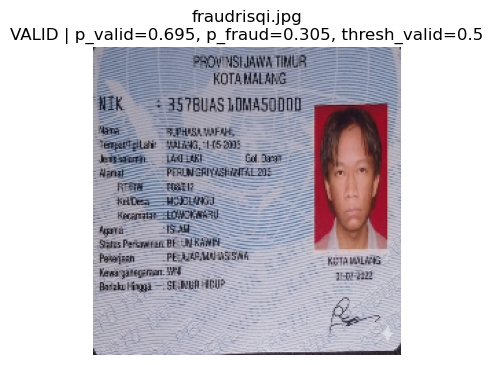

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
 2. image.png
     p_valid : 0.961
     p_fraud : 0.039
     Status  : HIJAU (VALID)
----------------------------------------


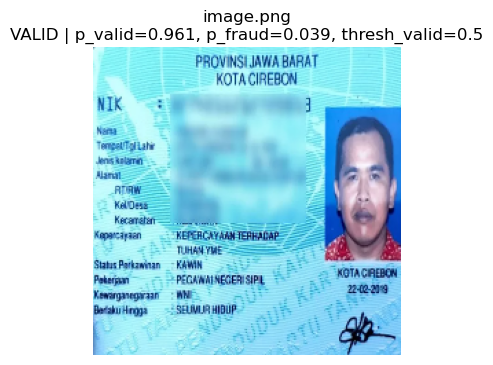

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
 3. images.jpg
     p_valid : 0.031
     p_fraud : 0.969
     Status  : MERAH (FRAUD)
----------------------------------------


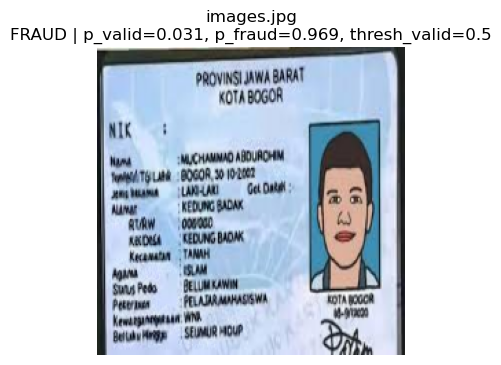

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
 4. ktpjuan.jpg
     p_valid : 0.927
     p_fraud : 0.073
     Status  : HIJAU (VALID)
----------------------------------------


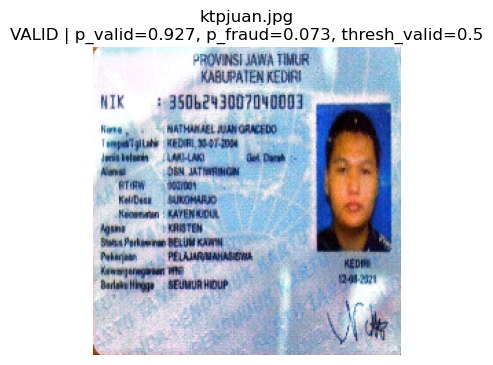

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
 5. ktpohim.jpeg
     p_valid : 0.017
     p_fraud : 0.983
     Status  : MERAH (FRAUD)
----------------------------------------


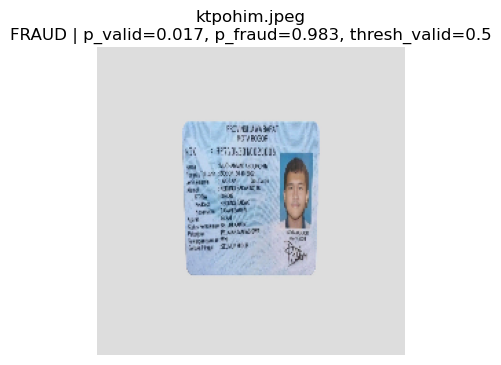

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
 6. ktppalsu.jpeg
     p_valid : 0.074
     p_fraud : 0.926
     Status  : MERAH (FRAUD)
----------------------------------------


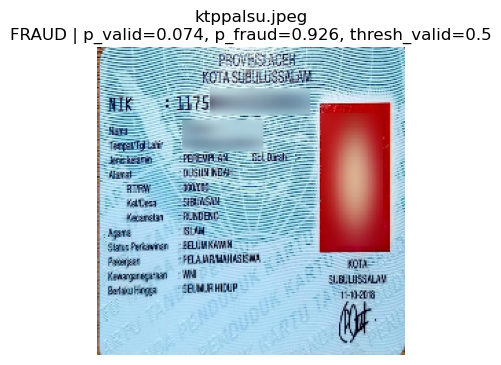

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
 7. ktppalsu1.jpg
     p_valid : 0.979
     p_fraud : 0.021
     Status  : HIJAU (VALID)
----------------------------------------


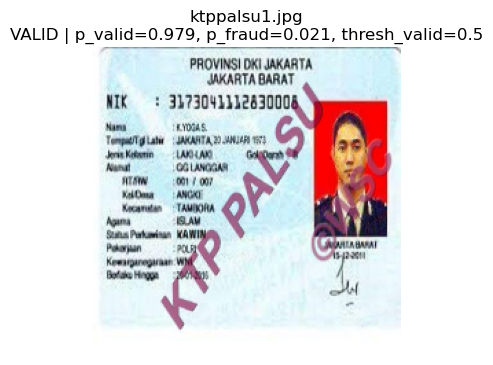

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
 8. pp.jpg
     p_valid : 0.014
     p_fraud : 0.986
     Status  : MERAH (FRAUD)
----------------------------------------


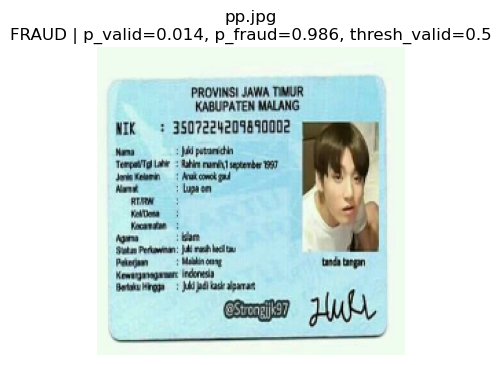


SUMMARY HASIL PREDIKSI
Total File Diproses : 8
KTP VALID           : 4 file
KTP FRAUD           : 4 file
Persentase Fraud    : 50.0%


In [5]:
# Cell 4: Jalankan prediksi di folder eksternal (mis: Fraud_Detectio/coba)

EXTERNAL_FOLDER = os.path.join(BASE_DIR, "Fraud_Detectio", "coba")

print("EXTERNAL_FOLDER:", EXTERNAL_FOLDER)

if os.path.isdir(EXTERNAL_FOLDER):
    res = predict_folder_ktp(
        loaded_model,
        EXTERNAL_FOLDER,
        thresh_valid=0.5,
        show_all_images=True
    )
else:
    print(f"Folder tidak ditemukan: {EXTERNAL_FOLDER}")
